In [1]:
import os
import sys
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

import matplotlib.pyplot as plt
from tqdm import tqdm

root_dir = os.getcwd().split("AdversarialNIDS")[0] + "AdversarialNIDS"
sys.path.append(root_dir)

from scripts.logger import LoggerManager
from scripts.analysis.model_analysis import perform_model_analysis

from CICIDS2017.dataset import CICIDS2017

from scripts.models.pytorch.MLP import NetworkIntrusionMLP

from scripts.models.pytorch.train import train
from scripts.models.pytorch.visualization import display_loss

from NIDS_attacks.fgsm import attack_fgsm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

lm = LoggerManager(
    log_dir=f"{root_dir}/results/logs",
    log_name="TDM",
)
logger = lm.get_logger()
title = lm.get_title()
logger.info(f"Logger initialized for '{title}'")
logger.info(f"Using device: {device}")

2025-11-25 08:33:56,199 - INFO - Logger initialized for 'TDM_20251125_083356'
2025-11-25 08:33:56,201 - INFO - Using device: cpu


In [2]:
full_dataset = CICIDS2017( # [UNSWNB15() or CICIDS2017()]
    dataset_size="small",
    logger=logger
).optimize_memory().encode(attack_encoder="label")

dataset = full_dataset.subset(size=900*1000, multi_class=True)

X_train, X_val, y_train, y_val = dataset.split(
    one_hot=True,
    apply_smote=False,
    to_tensor=True
)

# Create DataLoaders
train_dataset = TensorDataset(X_train.to(device), y_train.to(device))
val_dataset = TensorDataset(X_val.to(device), y_val.to(device))

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

2025-11-25 08:33:56,213 - INFO - Downloading dataset: sweety18/cicids2017-full-dataset
2025-11-25 08:33:56,819 - INFO - Loading dataset into DataFrame
2025-11-25 08:34:10,322 - INFO - Initial dimensions: 2,214,469 rows x 79 columns = 174,943,051 cells
2025-11-25 08:34:25,620 - INFO - ============================================================
2025-11-25 08:34:25,620 - INFO - Preprocessing completed successfully
2025-11-25 08:34:25,622 - INFO - Final dimensions: 1,940,693 rows x 71 columns
2025-11-25 08:34:25,622 - INFO - Total rows removed: 273,776 (12.36%)
2025-11-25 08:34:25,623 - INFO - data retention rate: 87.64%
2025-11-25 08:34:25,623 - INFO - ============================================================
2025-11-25 08:34:25,625 - INFO - Optimizing memory usage of the dataset...
2025-11-25 08:34:25,628 - INFO - Initial memory usage: 1066.05 MB
2025-11-25 08:34:26,299 - INFO - Optimized memory usage: 555.24 MB
2025-11-25 08:34:26,300 - INFO - Memory reduction: 510.82 MB (47.92%)
20

In [3]:
input_size = train_loader.dataset.tensors[0].shape[1]
num_classes = train_loader.dataset.tensors[1].shape[1]
print(f"Input Size: {input_size}, Num Classes: {num_classes}")

model_mlp = NetworkIntrusionMLP(
    input_size=input_size,
    num_classes=num_classes,
    device=device
)
model_mlp = model_mlp.load_model(f"{root_dir}/NIDS_attacks/pytorch_attack/MLP{input_size}x{num_classes}.400.pt")

Input Size: 70, Num Classes: 4


2025-11-25 08:34:31,799 - INFO - Running analysis for PyTorch model: Model on device: cpu


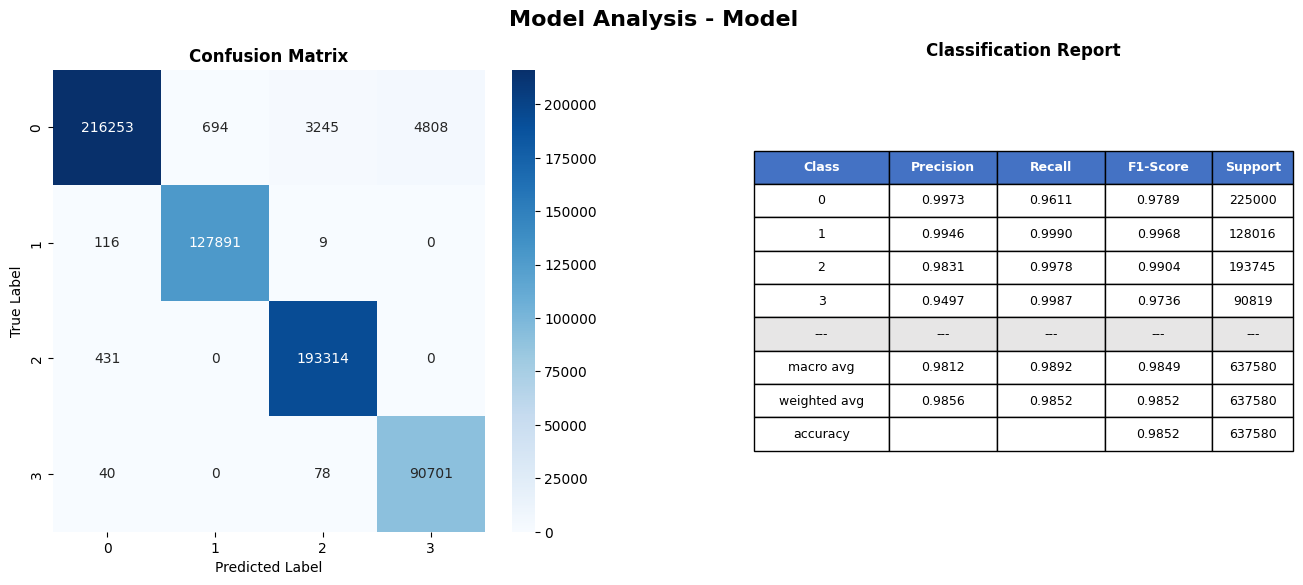

In [4]:
cm, cr = perform_model_analysis(
    model=model_mlp,
    X_test=torch.vstack((X_train, X_val)),
    y_test=torch.vstack((y_train, y_val)),
    logger=logger,
    save_fig=False,
    plot=True,
    device=device
)

In [5]:
# Let's define our adversarial input: 
# it is a copy of our original input, and we will need to be able to compute the gradient with respect to that input

attack_indices = dataset.is_attack[dataset.is_attack == 1].index.tolist()
random_idx = torch.randperm(len(attack_indices))[0]

adversarial_attack_input = dataset.features.iloc[attack_indices[random_idx]].values.astype('float32')

# To Tensor
adversarial_attack_input = torch.FloatTensor(adversarial_attack_input).clone().detach().requires_grad_(True)
adversarial_attack_input = adversarial_attack_input.unsqueeze(0).to(device)

print("Original input:", adversarial_attack_input)

Original input: tensor([[8.0000e+01, 8.4944e+07, 6.0000e+00, 6.0000e+00, 3.8000e+02, 1.1595e+04,
         3.8000e+02, 0.0000e+00, 6.3333e+01, 1.5513e+02, 4.3440e+03, 0.0000e+00,
         1.9325e+03, 1.7548e+03, 1.4097e+02, 1.4127e-01, 7.7222e+06, 2.5600e+07,
         8.4800e+07, 1.0000e+00, 8.4800e+07, 1.7000e+07, 3.7900e+07, 8.4800e+07,
         1.0000e+00, 1.5067e+05, 3.0134e+04, 6.0244e+04, 1.3744e+05, 1.6000e+01,
         0.0000e+00, 0.0000e+00, 2.0000e+02, 2.0000e+02, 7.0634e-02, 7.0634e-02,
         0.0000e+00, 4.3440e+03, 9.2115e+02, 1.4977e+03, 2.2432e+06, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 9.9792e+02, 6.3333e+01, 1.9325e+03, 2.0000e+02,
         6.0000e+00, 3.8000e+02, 6.0000e+00, 1.1595e+04, 2.7400e+02, 2.3500e+02,
         1.0000e+00, 3.2000e+01, 5.0000e+00, 0.0000e+00, 5.0000e+00, 5.0000e+00,
         8.4800e+07, 0.0000e+00, 8.4800e+07, 8.4800e+07]],
       grad_fn=<UnsqueezeBackward0

In [6]:
x_adv = adversarial_attack_input.clone().detach().requires_grad_(True)
criterion = nn.CrossEntropyLoss()
target = torch.LongTensor([0]).to(device)  # Targeting the 'benign' class

model_mlp.eval()
epsilon = 1e-2

# Initial prediction
initial_x_adv, initial_loss, initial_pred = attack_fgsm(
    model=model_mlp,
    criterion=criterion,
    x_val=x_adv,
    target=target,
    eps=0.0
)

print("Initial prediction on adversarial input:", initial_pred, initial_pred.argmax())

for iter in range(100):
    x_adv, loss, pred = attack_fgsm(
        model=model_mlp,
        criterion=criterion,
        x_val=x_adv,
        target=target,
        eps=1e-2
    )

    if pred.argmax() == 0:
        break

print(f"Adversarial input after {iter+1} iterations:", pred, pred.argmax())
print("Magnitude of perturbation:", torch.norm(x_adv - initial_x_adv).item())

Initial prediction on adversarial input: [[ -3.9270105  -6.1680775  10.792181  -10.482446 ]] 2
Adversarial input after 28 iterations: [[ 4.7945595 -5.1181593  4.6626577 -8.125011 ]] 0
Magnitude of perturbation: 1.9369252920150757
